# P5 - Convolutioneel neuraal netwerk

## Richard Jansen 1762581

![](https://cdn.discordapp.com/attachments/808321877193916456/821681363957841930/unknown.png)

# libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random

from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers

from sklearn.model_selection import train_test_split

import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

# Data exploration

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


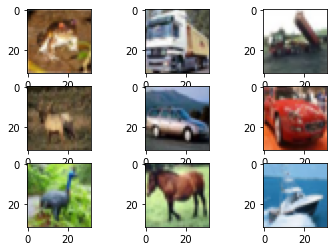

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i])
pyplot.show()

In [3]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [4]:
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


# data augmenttation

In [5]:
# Bereik / maximale waardes van de aanpassingen specificeren
rotation_range_val = 15
width_shift_val = 0.15
height_shift_val = 0.15
shear_range_val = 25
zoom_range_val = [0.9,1.1]
fill_mode_val = "wrap"


# Combineren in een ImageDataGenerator object
datagen = ImageDataGenerator(rotation_range = rotation_range_val,
                             width_shift_range = width_shift_val,
                             height_shift_range = height_shift_val,
                             fill_mode = fill_mode_val,
                             zoom_range=zoom_range_val)

In [6]:
datagen.fit(X_test)

X_test_augmented, Y_test_augmented = next(datagen.flow(X_test, y_test, batch_size=X_test.shape[0], shuffle=False))

Test: X=(10000, 32, 32, 3), y=(10000, 10)


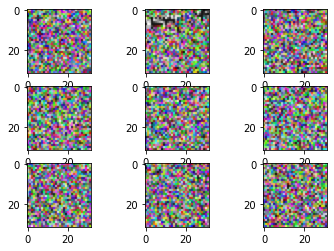

In [7]:
print('Test: X=%s, y=%s' % (X_test_augmented.shape, Y_test_augmented.shape))

for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow((X_test_augmented[i] * 255).astype(np.uint8))
pyplot.show()

# analyse

De data bestaad dus uit een plaatjes van **32x32 met 3 kleur kanalen**, dit is belangrijke informatie om uiteindelijk filter grote te bepalen en hoeveel filters

merk op dat hierboven de plaatjes ook op rand staan dus er moet ook gebruik gemaakt worden van **Zero padding**

## filter grote keuze en layer opbouw

### input layer
voor de eerste layer is het logish om dan 32 filters te nemen met een grote van 3x3 (3x3 is een normaal gebruikte grote voor dit soort cnn oplossingen). 

Voor de activatie methode maak ik gebruik van de relu activatie, uit verschilende testen kwam deze met het hoogste resultaat

Na de activatie maak ik gebruik van BatchNormalization, in het algemeen is dit toepasbaar voor elke layer voor een robuust netwerk

Na het normaliseren maak ik gebruik van maxpooling om de image te verkleinen en "algemene" waardens te krijgen, hierdoor wordt de output van deze laag verkleint naar 16x16x3

Elke layer geef ik een dropout mee maar bij de eerste layer is het beter om niet een te grote waarde op tegeven want dit is immers je input van het model. Daarom is de dropout hier 0.2

### tussen layers

Belangrijke note voor mijn gedachte gang, ik wil maximaal 3 layers voor de output hebben zitten ivm kleur channels
Het zou tof zijn als het netwerk in de eerste/2d laag kleuren zou herkennen en groeperen en de 2 lagen erna vormen gaat herkennen met de toenamen in aantals filters door filters x 2 tedoen voor elke laag

Voor elk volgende layer die ik toevoeg worden een aantal dingen continue hergebruikt zoals;

**activatie = relu**

**BatchNormalization**

**Maxpooling 2x2**

De filter grote wordt per laag met x2 vergroot in de hoop dat het steeds meer verschillende dingen kan combineren van de voorgaande input

De dropout verhoog ik met elke laag met 0.1 omdat er ook meer filters worden gebruikt en eigenlijk dus ook mogelijk een hoop duplicaat filers.

### Output laag

Aan het einde van het netwerk flatten ik de outkomst en zorg ervoor dat het netwerk dezelfde uitkomst grote heeft als de target, in dit geval doe **10** classes

De activatie functie is hier dan ook softmax om de juiste keuze te maken, 1 uitkomst*


# make model

# Baseline Model \ /

In [8]:
model_baseline =Sequential()
# Input layer
model_baseline.add(Conv2D(filters = 32, kernel_size =(3,3), input_shape=(32, 32, 3)))
model_baseline.add(Activation('relu'))
model_baseline.add(MaxPooling2D(pool_size=(2,2)))

# 2e layer
model_baseline.add(Conv2D(filters = 32, kernel_size =(3,3)))
model_baseline.add(Activation('relu'))
model_baseline.add(MaxPooling2D(pool_size=(2,2)))

model_baseline.add(Flatten())
model_baseline.add(Dense(10, activation='softmax'))

In [9]:
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

# Fancy model \ /

In [10]:
model_fancy = Sequential()
# Input layer
model_fancy.add(Conv2D(filters = 32, kernel_size =(3,3), padding='same', input_shape=(32, 32, 3)))
model_fancy.add(Activation('relu'))
model_fancy.add(BatchNormalization())
model_fancy.add(MaxPooling2D(pool_size=(2,2)))
model_fancy.add(Dropout(0.2))

# 2e layer
model_fancy.add(Conv2D(filters = 64, kernel_size = (3,3), padding='same'))
model_fancy.add(Activation('relu'))
model_fancy.add(BatchNormalization())
model_fancy.add(MaxPooling2D(pool_size=(2,2)))
model_fancy.add(Dropout(0.3))

# 3e Layer
model_fancy.add(Conv2D(filters = 128, kernel_size = (3,3), padding='same'))
model_fancy.add(Activation('relu'))
model_fancy.add(BatchNormalization())
model_fancy.add(MaxPooling2D(pool_size=(2,2)))
model_fancy.add(Dropout(0.4))

model_fancy.add(Flatten())
model_fancy.add(Dense(10, activation='softmax'))

In [11]:
model_fancy.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 16, 16, 64)       

# Compiler argumenten
Voor het compilen heb ik verschillenden optimizers gebruikt maar er zit bijna/geen verschillen tussen alle adam optimizers of varianten er van

ik heb ook andere geprobeerd maar die preseteren nog slechter

Het zelfde gelt voor de loss argument

## Compile baseline \ /

In [12]:
model_baseline.compile(loss="categorical_crossentropy",metrics=["accuracy"])

# Compile fancy model \ /

In [13]:
model_fancy.compile(loss="categorical_crossentropy", optimizer= 'adam', metrics=["accuracy"])

# Train models

## Train baseline

In [14]:
history_baseline  = model_baseline.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.1)

Epoch 1/100
704/704 [==============================] - 5s 6ms/step - loss: 5.2889 - accuracy: 0.1337 - val_loss: 2.2394 - val_accuracy: 0.2862
Epoch 2/100
704/704 [==============================] - 3s 5ms/step - loss: 1.9229 - accuracy: 0.3171 - val_loss: 1.7565 - val_accuracy: 0.3930
Epoch 3/100
704/704 [==============================] - 3s 5ms/step - loss: 1.6646 - accuracy: 0.4149 - val_loss: 1.6350 - val_accuracy: 0.4338
Epoch 4/100
704/704 [==============================] - 4s 5ms/step - loss: 1.5108 - accuracy: 0.4744 - val_loss: 1.5942 - val_accuracy: 0.4580
Epoch 5/100
704/704 [==============================] - 3s 5ms/step - loss: 1.4531 - accuracy: 0.4920 - val_loss: 1.9217 - val_accuracy: 0.4192
Epoch 6/100
704/704 [==============================] - 3s 5ms/step - loss: 1.3840 - accuracy: 0.5179 - val_loss: 1.7851 - val_accuracy: 0.4458
Epoch 7/100
704/704 [==============================] - 3s 5ms/step - loss: 1.3588 - accuracy: 0.5354 - val_loss: 1.6490 - val_accuracy: 0.4722

Epoch 58/100
704/704 [==============================] - 4s 5ms/step - loss: 1.4556 - accuracy: 0.5277 - val_loss: 1.7240 - val_accuracy: 0.4262
Epoch 59/100
704/704 [==============================] - 4s 5ms/step - loss: 1.4232 - accuracy: 0.5305 - val_loss: 1.8717 - val_accuracy: 0.3870
Epoch 60/100
704/704 [==============================] - 4s 5ms/step - loss: 1.4536 - accuracy: 0.5225 - val_loss: 2.4711 - val_accuracy: 0.3622
Epoch 61/100
704/704 [==============================] - 4s 6ms/step - loss: 1.5003 - accuracy: 0.5112 - val_loss: 1.7750 - val_accuracy: 0.4338
Epoch 62/100
704/704 [==============================] - 4s 6ms/step - loss: 1.4675 - accuracy: 0.5163 - val_loss: 2.1482 - val_accuracy: 0.3664
Epoch 63/100
704/704 [==============================] - 4s 5ms/step - loss: 1.4475 - accuracy: 0.5197 - val_loss: 1.7445 - val_accuracy: 0.5008
Epoch 64/100
704/704 [==============================] - 4s 5ms/step - loss: 1.4414 - accuracy: 0.5236 - val_loss: 1.8821 - val_accuracy:

## Train Fancy model

In [15]:
history_fancy  = model_fancy.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.1)

Epoch 1/100
704/704 [==============================] - 6s 8ms/step - loss: 2.3934 - accuracy: 0.3507 - val_loss: 1.4126 - val_accuracy: 0.5070
Epoch 2/100
704/704 [==============================] - 5s 7ms/step - loss: 1.4071 - accuracy: 0.5338 - val_loss: 1.2499 - val_accuracy: 0.5560
Epoch 3/100
704/704 [==============================] - 5s 7ms/step - loss: 1.1651 - accuracy: 0.6001 - val_loss: 0.9966 - val_accuracy: 0.6536
Epoch 4/100
704/704 [==============================] - 5s 7ms/step - loss: 1.0515 - accuracy: 0.6340 - val_loss: 0.9198 - val_accuracy: 0.6850
Epoch 5/100
704/704 [==============================] - 5s 7ms/step - loss: 0.9605 - accuracy: 0.6657 - val_loss: 0.9064 - val_accuracy: 0.6856
Epoch 6/100
704/704 [==============================] - 5s 7ms/step - loss: 0.9012 - accuracy: 0.6833 - val_loss: 0.8908 - val_accuracy: 0.6894
Epoch 7/100
704/704 [==============================] - 5s 7ms/step - loss: 0.8624 - accuracy: 0.6983 - val_loss: 1.0528 - val_accuracy: 0.6536

Epoch 58/100
704/704 [==============================] - 5s 8ms/step - loss: 0.4826 - accuracy: 0.8243 - val_loss: 0.5661 - val_accuracy: 0.8188
Epoch 59/100
704/704 [==============================] - 5s 8ms/step - loss: 0.4771 - accuracy: 0.8293 - val_loss: 0.5924 - val_accuracy: 0.8068
Epoch 60/100
704/704 [==============================] - 5s 8ms/step - loss: 0.4807 - accuracy: 0.8297 - val_loss: 0.5576 - val_accuracy: 0.8140
Epoch 61/100
704/704 [==============================] - 5s 8ms/step - loss: 0.4762 - accuracy: 0.8306 - val_loss: 0.5985 - val_accuracy: 0.8014
Epoch 62/100
704/704 [==============================] - 5s 8ms/step - loss: 0.4713 - accuracy: 0.8321 - val_loss: 0.6639 - val_accuracy: 0.7906
Epoch 63/100
704/704 [==============================] - 5s 8ms/step - loss: 0.4759 - accuracy: 0.8347 - val_loss: 0.5774 - val_accuracy: 0.8090
Epoch 64/100
704/704 [==============================] - 5s 8ms/step - loss: 0.4685 - accuracy: 0.8337 - val_loss: 0.5358 - val_accuracy:

# Evaluatie baseline

In [16]:
loss, accuracy = model_baseline.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 1s 2ms/step - loss: 2.2117 - accuracy: 0.4173
Test loss: 2.2117
Test accuracy: 0.4173


In [17]:
# score X_test_augmented
score = model_baseline.evaluate(X_test_augmented, Y_test_augmented)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 3.3414 - accuracy: 0.3353
Test score: 3.3414363861083984
Test accuracy: 0.3352999985218048


# plotting

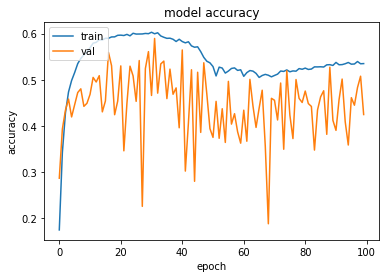

In [18]:
plt.plot(history_baseline.history['accuracy'])
plt.plot(history_baseline.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

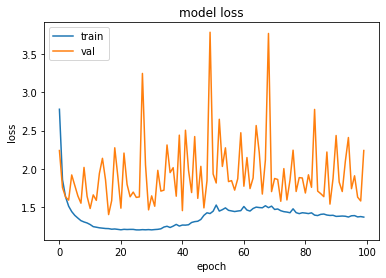

In [19]:
plt.plot(history_baseline.history['loss'])
plt.plot(history_baseline.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluatie Fancy model

In [20]:
loss, accuracy = model_fancy.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.5750 - accuracy: 0.8082
Test loss: 0.5750
Test accuracy: 0.8082


In [21]:
# score X_test_augmented
score = model_fancy.evaluate(X_test_augmented, Y_test_augmented)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.9390 - accuracy: 0.6902
Test score: 0.9389877915382385
Test accuracy: 0.6901999711990356


# plotting

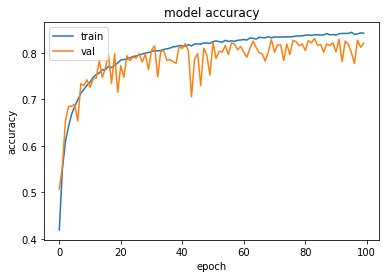

In [22]:
plt.plot(history_fancy.history['accuracy'])
plt.plot(history_fancy.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

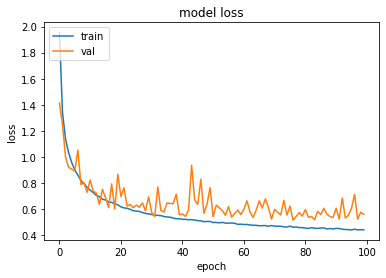

In [23]:
plt.plot(history_fancy.history['loss'])
plt.plot(history_fancy.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# conclusie

Deze dataset kan ik maximaal op 80% kregen van accuracy op de validatie set

dit is wel bijna 2x zo hoog als de baseline :)